In [1]:
%matplotlib inline
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from torch.autograd import Variable
import nibabel as nib
import pandas as pd
from torch.utils import data
import random
from sklearn.model_selection import KFold
import argparse
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from scipy.spatial import distance_matrix
import pathlib, sys, os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,f1_score,silhouette_score,recall_score,classification_report,confusion_matrix
from scipy.stats import ttest_ind
from mpl_toolkits.mplot3d import Axes3D   
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA
import seaborn as sns
from IPython.display import display, HTML
from scipy.stats import spearmanr,pearsonr, ttest_ind
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from nilearn import plotting
from scipy.ndimage import gaussian_filter
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
        '#notebook-container {padding: 0px;}'
    '</style>'
))

# Save data

In [7]:
data_name = "T1_ADVDLBD_Mlabel_10fold_0307v2"
pth_nii = '/media/dw/Data/BINC_T1/BINC/dropbox/nacc_harmonized_may023/beforeHarm_3DSminmax/'
pth = "/home/dw/Desktop/DemCLF/data/data_Mlabel_10fold_0307/"
mri_IDs = []
save_folder = '/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/'
pathlib.Path(save_folder).mkdir(parents=True, exist_ok=True)
print(save_folder)

for fold in range(0,10):
    df_train = pd.read_csv(pth + data_name + "_train_f" + str(fold) + ".csv")
    X_train,y_train = [],[]
    for i,r in df_train.iterrows():
        name = r['mri_ID']
        niia = nib.load(pth_nii + name).get_fdata().flatten()
        X_train.append(niia)
        y_train.append(r[['AD','VD','LBD']].tolist())
    np.save(save_folder+"/X_train_f" + str(fold)+".npy",X_train)
    np.save(save_folder+"/y_train_f" + str(fold)+".npy",y_train)
    
    df_test = pd.read_csv(pth + data_name + "_test_f" + str(fold) + ".csv")
    X_test,y_test = [],[]
    for i,r in df_test.iterrows():
        name = r['mri_ID']
        niia = nib.load(pth_nii + name).get_fdata().flatten()
        X_test.append(niia)
        y_test.append(r[['AD','VD','LBD']].tolist())
        mri_IDs.append(name)
    np.save(save_folder+"/X_test_f" + str(fold)+".npy",X_test)
    np.save(save_folder+"/y_test_f" + str(fold)+".npy",y_test)
        

/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/


In [8]:
data_name = "T1_ADVDLBD_Mlabel_10fold_0307v2"
 
pth = "/home/dw/Desktop/DemCLF/data/data_Mlabel_10fold_0307/"
mri_IDs = []

for fold in range(0,10):
    df_test = pd.read_csv(pth + data_name + "_test_f" + str(fold) + ".csv")
    X_test,y_test = [],[]
    for i,r in df_test.iterrows():
        name = r['mri_ID']
        mri_IDs.append(name)
mri_IDs = [i[0:19] for i in mri_IDs]
len(mri_IDs)   

784

# 3DS RF

In [15]:
data_folder = '/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/'
save_folder = '/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/RF/'
pathlib.Path(save_folder).mkdir(parents=True, exist_ok=True)
print(save_folder)

for n_estimators in [20,50,100,200,300,400]: #,50,100,200,300,400
    all_t = []
    all_p = []
    all_probAD = []
    all_probVD = []
    all_probOD = []
    
    for fold in range(0,10):
        X_train = np.load(data_folder + "/X_train_f" + str(fold)+".npy")
        y_train = np.load(data_folder + "/y_train_f" + str(fold)+".npy")

        X_test = np.load(data_folder + "/X_test_f" + str(fold)+".npy")
        y_test = np.load(data_folder + "/y_test_f" + str(fold)+".npy")



        clf =RandomForestClassifier(n_estimators = n_estimators).fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        all_p.extend(y_predict)
        all_t.extend(y_test)
        y_prob = clf.predict_proba(X_test)
        all_probAD.extend(y_prob[0][:,1])
        all_probVD.extend(y_prob[1][:,1])
        all_probOD.extend(y_prob[2][:,1])


    all_p = np.array(all_p)
    all_t = np.array(all_t)



    ac1 = precision_score(all_t, all_p, average='micro',zero_division =0)
    ac2 = recall_score(all_t, all_p, average='micro')
    ac3 = f1_score(all_t, all_p, average='micro')
    ac4 = balanced_accuracy_score(all_t[:,0],all_p[:,0])
    ac5 = balanced_accuracy_score(all_t[:,1],all_p[:,1])
    ac6 = balanced_accuracy_score(all_t[:,2],all_p[:,2])
    ac7 = (ac4 + ac5+ ac6)/3
    # ac7 = (ac4 + ac5)/2
    print("\n #### Random Forest, n_estimators="+str(n_estimators))
    print('precision',np.round(ac1,3))
    print('recall',np.round(ac2,3))
    print('F1',np.round(ac3,3))
    print('AD acc',np.round(ac4,3))
    print('VD acc',np.round(ac5,3))
    print('LBD acc',np.round(ac6,3))
    print('AVE acc',np.round(ac7,3))
    
    df = pd.DataFrame(all_t, columns = ['AD','VD','LBD'])
    df.insert(loc = 2, column = 'probVD',value = all_probVD)
    df.insert(loc = 2, column = 'probAD',value = all_probAD)
    df.insert(loc = 2, column = 'probLBD',value = all_probOD)
    df.insert(loc = 4, column = 'VD_pred',value = np.array(all_p)[:,0])
    df.insert(loc = 4, column = 'AD_pred',value = np.array(all_p)[:,1])
    df.insert(loc = 4, column = 'LBD_pred',value = np.array(all_p)[:,2])
    df.insert(loc = 0, column = 'mri_ID',value = mri_IDs)
    df.to_csv(save_folder+"/RF_prob_n"+str(n_estimators)+".csv")

/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/RF/

 #### Random Forest, n_estimators=20
precision 0.73
recall 0.519
F1 0.606
AD acc 0.724
VD acc 0.741
LBD acc 0.499
AVE acc 0.655

 #### Random Forest, n_estimators=50
precision 0.747
recall 0.601
F1 0.666
AD acc 0.755
VD acc 0.795
LBD acc 0.5
AVE acc 0.683

 #### Random Forest, n_estimators=100
precision 0.759
recall 0.611
F1 0.677
AD acc 0.786
VD acc 0.784
LBD acc 0.5
AVE acc 0.69

 #### Random Forest, n_estimators=200
precision 0.752
recall 0.624
F1 0.682
AD acc 0.779
VD acc 0.797
LBD acc 0.5
AVE acc 0.692

 #### Random Forest, n_estimators=300
precision 0.764
recall 0.625
F1 0.688
AD acc 0.786
VD acc 0.802
LBD acc 0.5
AVE acc 0.696

 #### Random Forest, n_estimators=400
precision 0.758
recall 0.629
F1 0.688
AD acc 0.785
VD acc 0.802
LBD acc 0.5
AVE acc 0.696


In [2]:
n_estimators = 300
df = pd.read_csv("/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/RF/RF_prob_n"+str(n_estimators)+".csv")
df

,Unnamed: 0,mri_ID,AD,VD,probLBD,probAD,LBD_pred,AD_pred,VD_pred,probVD,LBD
0,0,NACC787965_20111209,0,1,0.266667,0.596667,0,1,1,0.583333,1
1,1,941_S_1202_20110616,0,0,0.133333,0.250000,0,0,0,0.253333,0
2,2,NACC677253_20121221,0,0,0.230000,0.576667,0,1,1,0.603333,0
3,3,035_S_0555_20060606,0,0,0.236667,0.356667,0,0,0,0.343333,0
4,4,NACC038701_20161027,0,0,0.183333,0.206667,0,0,0,0.196667,0
...,...,...,...,...,...,...,...,...,...,...,...
779,779,NACC150858_20160613,0,0,0.163333,0.216667,0,0,0,0.236667,0
780,780,NACC110437_20090506,0,0,0.056667,0.133333,0,0,0,0.173333,0
781,781,022_S_0096_20060118,0,0,0.120000,0.296667,0,0,0,0.263333,0
782,782,098_S_0269_20110402,1,1,0.306667,0.726667,0,1,1,0.720000,0


/tmp/ipykernel_7054/555195725.py:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()], fontsize=12)
/tmp/ipykernel_7054/555195725.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()], fontsize=12)


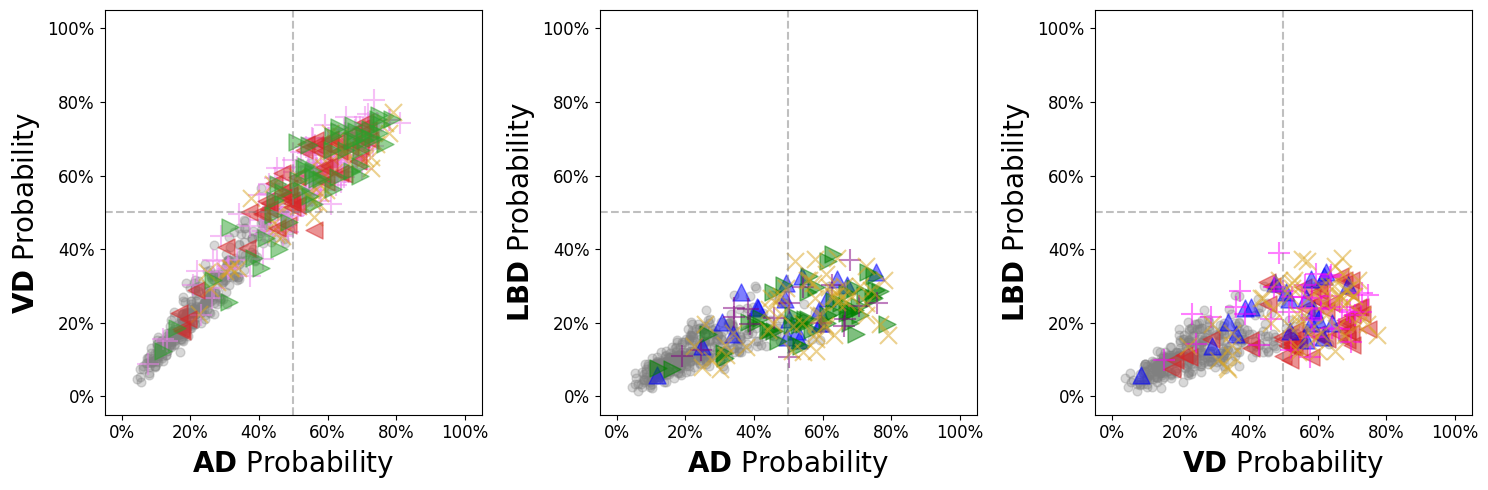

In [3]:
fig,axs = plt.subplots(ncols = 3,nrows=1,figsize = (15,5))
axs = axs.flatten()


s = 150    
f1,f2 ='probAD','probVD'

fs = 20

# axs[0].scatter(-100,-100, label = "CN", marker='o', alpha = 0.5, s =40, color = 'gray')
# axs[0].scatter(-100,-100, label = "AD", marker='>', alpha = 0.5, s =s, color = '#2CA02C')
# axs[0].scatter(-100,-100, label = "VD", marker='<', alpha = 0.5, s =s, color = '#D62728')
# axs[0].scatter(-100,-100, label = "LBD", marker='^', alpha = 0.5, s =s, color = 'blue')
# axs[0].scatter(-100,-100, label = "AD+VD", marker='+', alpha = 0.5, s =s+100, color = 'violet')
# axs[0].scatter(-100,-100, label = "AD+LBD", marker='+', alpha = 0.5, s =s+100, color = 'purple')
# axs[0].scatter(-100,-100, label = "VD+LBD", marker='+', alpha = 0.5, s =s+100, color = 'magenta')
# axs[0].scatter(-100,-100, label = "AD+VD+LBD", marker='x', alpha = 0.5, s =s, color = 'goldenrod')
# axs[0].legend(prop={'size': 20},bbox_to_anchor=(1, 0.53, 0.5, 0.5))

axs[0].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f2]], 
             marker='o', alpha = 0.3, s =40, color = 'gray')

axs[0].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 0)][[f2]], 
             marker='+', alpha = 0.5, s =s+100, color = 'violet')

axs[0].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f2]], 
            marker='x', alpha = 0.5, s =s, color = 'goldenrod')
axs[0].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 0)][[f2]], 
             marker='<', alpha = 0.5, s =s, color = '#D62728')

axs[0].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 0)][[f2]], 
             marker='>', alpha = 0.5, s =s, color = '#2CA02C')

axs[0].set_xlabel(r'$\bf{AD}$ Probability', fontsize = fs)
axs[0].set_ylabel(r'$\bf{VD}$ Probability', fontsize = fs)    



f1,f2 ='probAD','probLBD'
axs[1].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f2]], 
            marker='o', alpha = 0.3, s =40, color = 'gray')

axs[1].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 1)][[f2]], 
             marker='^', alpha = 0.5, s =s, color = 'blue')

axs[1].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 0)][[f2]], 
            marker='>', alpha = 0.5, s =s, color = 'green')

axs[1].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 1)][[f2]], 
             marker='+', alpha = 0.5, s =s+100, color = 'purple')

axs[1].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f2]], 
             marker='x', alpha = 0.5, s =s, color = 'goldenrod')

axs[1].set_xlabel(r'$\bf{AD}$ Probability', fontsize = fs)
axs[1].set_ylabel(r'$\bf{LBD}$ Probability', fontsize = fs) 


f1,f2 ='probVD','probLBD'
axs[2].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f2]], 
            marker='o', alpha = 0.3, s =40, color = 'gray')

axs[2].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 0)][[f2]], 
            marker='<', alpha = 0.5, s =s, color = '#D62728')

axs[2].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 1)][[f2]], 
            marker='^', alpha = 0.5, s =s, color = 'blue')

axs[2].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 1)][[f2]], 
             marker='+', alpha = 0.5, s =s+100, color = 'magenta')

axs[2].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f2]], 
             marker='x', alpha = 0.5, s =s, color = 'goldenrod')

axs[2].set_xlabel( r'$\bf{VD}$ Probability', fontsize = fs)
axs[2].set_ylabel(r'$\bf{LBD}$ Probability', fontsize = fs)
    


# plt.xlim([-0.05,1.05])
# plt.ylim([-0.05,1.05])
# plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
# plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

# axs[0].set_title("Deep Learning Chart", fontsize = 20)
# plt.grid(linestyle = '--')
for i in range(0,3):
    axs[i].axvline(x = 0.5, linestyle = '--', color='gray', alpha = 0.5)
    axs[i].axhline(y = 0.5, linestyle = '--', color='gray', alpha = 0.5)
    axs[i].set_xlim([-0.05,1.05])
    axs[i].set_ylim([-0.05,1.05])
    
for i in range(0,3):    
    axs[i].set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()], fontsize=12) 
    axs[i].set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()], fontsize=12) 

    
fig.tight_layout()

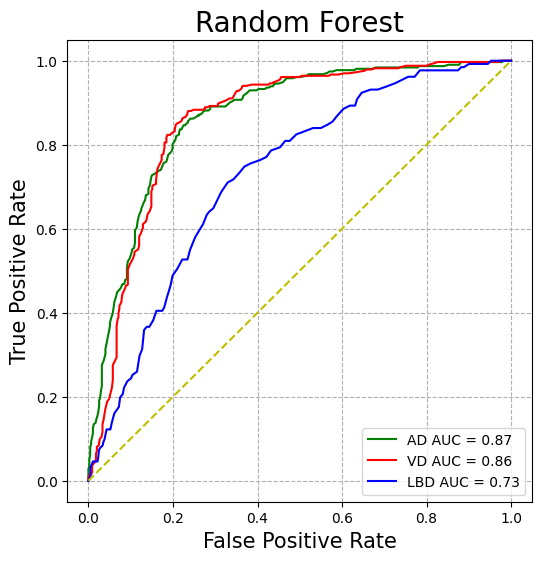

In [22]:
fpr, tpr, threshold = metrics.roc_curve(df.AD.values.tolist(), df.probAD.values.tolist())
roc_auc = metrics.auc(fpr, tpr)

fpr2, tpr2, threshold2 = metrics.roc_curve(df.VD.values.tolist(), df.probVD.values.tolist())
roc_auc2 = metrics.auc(fpr2, tpr2)

fpr3, tpr3, threshold3 = metrics.roc_curve(df.LBD.values.tolist(), df.probLBD.values.tolist())
roc_auc3 = metrics.auc(fpr3, tpr3)

plt.figure(figsize=(6, 6))
plt.title('Random Forest', fontsize = 20)
plt.plot(fpr, tpr, 'g', label = 'AD AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'r', label = 'VD AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'b', label = 'LBD AUC = %0.2f' % roc_auc3)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'y--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.grid(linestyle = '--')
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xlabel('False Positive Rate', fontsize = 15)
plt.show()